# 0. Install and Import Dependencies

In [2]:
#Collecting all imports into 1 cell
import os
import cv2
import numpy as np
from typing import List
import imageio
import gdown
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Bidirectional, LSTM, Dense, Dropout, TimeDistributed, Reshape, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.models import load_model

# 1. Build Data Loading Functions

In [3]:
gdown.download('https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL', 'data.zip', quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=a32c4caa-ab3b-47e6-8898-49060cae1e77
To: /content/data.zip
100%|██████████| 423M/423M [00:03<00:00, 114MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [4]:
def load_video(path):
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [5]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [6]:
char_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_char = tf.keras.layers.StringLookup(vocabulary=char_num.get_vocabulary(), oov_token="", invert=True)

In [7]:
def load_alignments(path):
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens.extend([' ', line[2]])
    return char_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'),(-1)))[1:]

In [8]:
def load_data(path):
  if type(path)!=str:
    path = path.numpy().decode('utf-8')
  temp=path.split("/")
  if temp[0]==".":
    path=temp[1:]
  else:
    path=temp
  video_path = os.path.join(path[0],path[1],path[2])
  alignment_path = os.path.join(path[0],'alignments',path[1],f'{path[2][:-4]}.align')
  frames = load_video(video_path)
  alignments = load_alignments(alignment_path)
  return frames, alignments

bin blue at l six now


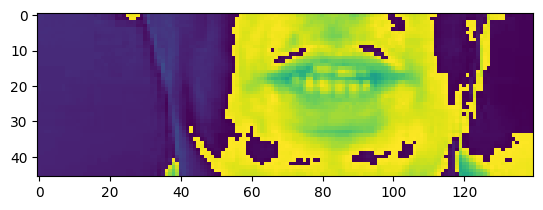

In [9]:
test_path="./data/s1/bbal6n.mpg"
frames, alignments = load_data(test_path)
print(''.join(x.decode() for x in num_char(alignments).numpy()))
plt.imshow(frames[40])

In [10]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [11]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)

data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split
train = data.take(480)
test = data.skip(480)

lay green in l five soon


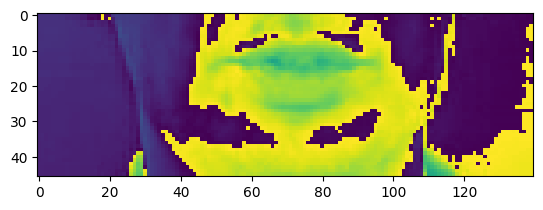

In [12]:
frames, alignments = data.as_numpy_iterator().next()
print(''.join(x.decode() for x in [num_char(word).numpy() for word in alignments[0]]))
plt.imshow(frames[0][40])

# 3. Design the Deep Neural Network

In [13]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [14]:
@tf.keras.utils.register_keras_serializable()
class LipNet(tf.keras.Model):
    def __init__(self, dropout_p=0.5, num_classes=41, **kwargs):
        super(LipNet, self).__init__(**kwargs)
        self.dropout_p = dropout_p
        self.num_classes = num_classes

        # Pre-trained EfficientNet for feature extraction from each frame (expects 3 channels per frame)
        self.efficientnet = EfficientNetB0(input_shape=(46, 140, 3), include_top=False, weights='imagenet')
        self.efficientnet.trainable = False  # Freeze the weights

        self.time_distributed_efficientnet = layers.TimeDistributed(self.efficientnet)
        self.convert_to_rgb = layers.Conv3D(3, (1, 1, 1), padding='same', activation='relu')
        self.conv0 = layers.Conv3D(128, 3, padding='same')
        self.pool0 = layers.MaxPooling3D((1, 2, 2), padding='same')
        self.relu0 = layers.ReLU()
        self.conv1 = layers.Conv3D(256, 3, padding='same')
        self.pool1 = layers.MaxPooling3D((1, 2, 2), padding='same')
        self.relu1 = layers.ReLU()
        self.conv2 = layers.Conv3D(512, 3, padding='same')
        self.pool2 = layers.MaxPooling3D((1, 2, 2), padding='same')
        self.relu2 = layers.ReLU()
        self.lstm1 = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=self.dropout_p))
        self.dropout1 = layers.Dropout(self.dropout_p)
        self.lstm2 = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=self.dropout_p))
        self.dropout2 = layers.Dropout(self.dropout_p)
        self.fc = layers.Dense(self.num_classes, activation='softmax', kernel_initializer='he_normal')

    def call(self, inputs, training=False):
        x = self.convert_to_rgb(inputs)
        x = self.time_distributed_efficientnet(x)
        x = self.conv0(x)
        x = self.relu0(x)
        x = self.pool0(x)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = layers.Reshape((x.shape[1], -1))(x)
        x = self.lstm1(x)
        x = self.dropout1(x)
        x = self.lstm2(x)
        x = self.dropout2(x)
        x = self.fc(x)
        return x

    def get_config(self):
        config = super(LipNet, self).get_config()
        config.update({
            "dropout_p": self.dropout_p,
            "num_classes": self.num_classes,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


# Create an instance of the LipNet model
model = LipNet(dropout_p=0.5)

# Example input tensor with shape (batch_size, time_steps, height, width, channels)
input_tensor = tf.random.normal([8, 75, 46, 140, 1])  # Adjusted to match the input shape

# Call the model to build the model's layers and compute output shape
output_tensor = model(input_tensor)

# Print the model summary
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "lip_net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 2, 5, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (8, 75, 2, 5, 1280)         │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d (Conv3D)                      │ (8, 75, 46, 140, 3)         │               6 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (8, 75, 2, 5, 128)          │       4,423,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (8, 75, 1, 3, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (8, 75, 2, 5, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (8, 75, 1, 3, 256)          │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (8, 75, 1, 2, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (8, 75, 1, 3, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_3 (Conv3D)                    │ (8, 75, 1, 2, 512)          │       3,539,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (8, 75, 1, 1, 512)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (8, 75, 1, 2, 512)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (8, 75, 256)                │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (8, 75, 256)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (8, 75, 256)                │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (8, 75, 256)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (8, 75, 41)                 │          10,537 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,958,994 (53.25 MB)

 Trainable params: 9,909,423 (37.80 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

# 4. Setup Training Options and Train

In [15]:
@register_keras_serializable()
def scheduler(epoch, lr):
    if epoch < 50:
        return lr
    else:
        return lr * tf.math.exp(-0.3)

In [16]:
@register_keras_serializable()
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [17]:
# @register_keras_serializable()
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        y_pred = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(y_pred, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(y_pred)):

            print('Actual:', ''.join(x.decode() for x in [num_char(word).numpy() for word in data[1][x]]))
            print('Predicted:',''.join(x.decode() for x in [num_char(word).numpy() for word in decoded[x]]))
            print('-'*50)

In [18]:
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join('models', 'checkpoint_model.keras'),  # Save the model in HDF5 format
    monitor='loss',                                         # Monitor the loss for saving
    save_best_only=True,                                    # Save only the best model
    save_weights_only=False,                                # Save the full model (structure + weights)
    verbose=1                                               # Enable logging for clarity
)

In [19]:
schedule_callback = LearningRateScheduler(scheduler)
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [20]:
example_callback = ProduceExample(test)

# Load Existing Model Weights

In [22]:
# Ensure the class is imported or defined before this step
model = load_model("/content/checkpoint_model (18).keras")

# To Train Model

In [ ]:
# To train
with tf.device('/GPU:0'):
  model.compile(optimizer=Adam(learning_rate=0.001), loss=CTCLoss)
  model.fit(train, validation_data=test, epochs=10, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/10


# 5. Make a Prediction On Test Data

In [23]:
print('Actual and Predicted Labels:')

for batch in test.as_numpy_iterator():
  frames, alignments = batch
  with tf.device('/GPU:0'):
    y_pred = model.predict(frames)
  decoded = tf.keras.backend.ctc_decode(y_pred, input_length=[75,75], greedy=True)[0][0]
  actual = [''.join(x.decode() for x in [num_char(word).numpy() for word in sentence]) for sentence in alignments]
  predicted = [''.join(x.decode() for x in [num_char(word).numpy() for word in sentence]) for sentence in decoded]
  print("Actual :")
  print(actual)
  print("Predicted :")
  print(predicted)
  print("-" * 50)

Actual and Predicted Labels:
1/1 ━━━━━━━━━━━━━━━━━━━━ 184s 184s/step
Actual :
['place green with z one again', 'bin blue by s seven again']
Predicted :
['pan wrie it ie aoain', 'ban wree it ie soaw']
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
Actual :
['place white by k one soon', 'set green with d two please']
Predicted :
['bac wree it sie aoawn', 'ban wrie it ie aoain']
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
Actual :
['set blue at a seven again', 'lay green by s nine again']
Predicted :
['ban wrie it ie agawn', 'lac gree it fie aoawn']
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
Actual :
['bin blue with g two please', 'place red in i nine again']
Predicted :
['ban wree it eiee soaown', 'bac wree it sie aoawn']
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
Actual :
['place white by k two please', 'bi

# Test on a Video

In [24]:
sample = load_data("./data/s1/bras9a.mpg")

In [25]:
print('Actual :')
print(''.join(x.decode() for x in num_char(sample[1]).numpy()))

Actual :
bin red at s nine again


In [26]:
with tf.device('/GPU:0'):
  y_pred = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 206s 206s/step


In [27]:
decoded = tf.keras.backend.ctc_decode(y_pred, input_length=[75], greedy=True)[0][0]
print('Predicted :')
print([''.join(x.decode() for x in [num_char(word).numpy() for word in sentence]) for sentence in decoded])

Predicted :
['ban wrie it iee aoaon']
